In [1]:
# Code along based on the article by Jason Brownlee: 
# "Time Series Forecast Study with Python: Monthly Sales of French Champagne"
# https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore') #  Important for testing ARIMA Models
%matplotlib notebook

In [2]:
def process_temperature_file(dataset):
    dataset_series = pd.Series(dataset['MEAN TEMPERATURE'])
    dataset_series.index = pd.to_datetime(dataset_series.index, format='%Y-%m-%d')
    dataset_series.index.name = None
    dataset_series = dataset_series[dataset_series.values > 0]
    dataset_series.sort_index(inplace = True)
    return dataset_series

In [3]:
temperature = pd.read_csv('input/mean_temp_series_day.csv',
                         index_col = 'ACQUISITION TIME')
temperature = process_temperature_file(temperature)

In [4]:
def find_missing_dates(start_date, end_date, array_of_dates):
    rng = pd.date_range(start_date, end_date, freq='MS')
    x = np.in1d(rng, array_of_dates)
    x = np.invert(x)
    missing_values = rng[x]
    return missing_values

In [5]:
holes_in_dataset = find_missing_dates(pd.Timestamp('2000-01-01 00:00:00'),
                                      pd.Timestamp('2018-02-01 00:00:00'),
                                      temperature.index.values)
print(holes_in_dataset)

DatetimeIndex(['2000-01-01', '2005-12-01', '2007-12-01', '2011-12-01',
               '2017-12-01'],
              dtype='datetime64[ns]', freq=None)


### All records from December have to be deleted, a record from January could be approximated. I'll approximate ALL missing values with the mean value from the whole dataset but in the real-world it's not good idea to approximate missing values if there is a lot of them

In [6]:
def data_approximation(dataset, dates):
    unique_months = np.unique(dates.month)
    for m in unique_months:
        mean_for_month_m = (dataset[dataset.index.month == m]).mean()
        for d in dates:
            if d.month == m:
                temp_series = pd.Series(data = [mean_for_month_m], index = [d])
                dataset = dataset.append(temp_series)
    dataset.sort_index(inplace=True)
    return dataset

In [7]:
temperature_filled = data_approximation(temperature, holes_in_dataset)

## Quick look into a data

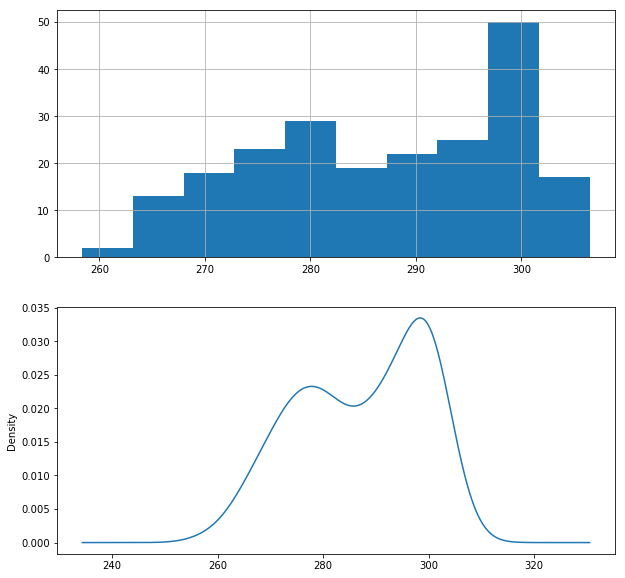

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(211)
temperature_filled.hist()
plt.subplot(212)
temperature_filled.plot(kind='kde')
plt.show()

## Split into training and validation sets

In [9]:
def prepare_data(dataset, save_training=True, save_validation=True):
    limit = len(dataset) - 2 * 12 - 2
    training = dataset[:limit]
    validation = dataset[limit:]
    print('Validation set is {0:.2f} % of training set'.format(100 * len(validation) / len(training)))
    if save_training:
        training.to_csv('input/training.csv')
    if save_validation:
        validation.to_csv('input/validation.csv')
    return training, validation

In [10]:
train_set, val_set = prepare_data(temperature_filled)

Validation set is 13.54 % of training set


## Test by walk-forward

In [11]:
def test_by_walk_forward(dataset):
    # Split data
    vX = dataset.values
    v_train_set = vX[:int(len(vX)/2)]
    v_test_set = vX[int(len(vX)/2):]

    # Walk-forward validation
    history = [v_train_set[-1]]
    predictions = list()
    for i in range(len(v_test_set)):
        # prediction
        y_ = history[-1]
        predictions.append(y_)
        # observation
        obs = v_test_set[i]
        history.append(obs)
    # error
    mse = mean_squared_error(v_test_set, predictions)
    rmse = np.sqrt(mse)
    print(rmse)

In [12]:
test_by_walk_forward(train_set)

7.27864486902


## ARIMA Model: data processing, make it stationary

In [13]:
def difference(dataset, interval=12):
    MONTHS = 12
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - MONTHS]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, dy, interval=12):
    return dy + history[-interval]

def make_data_stationary(dataset, months_per_period=12, save_data=False):
    stationary_data = difference(dataset.values, months_per_period)
    
    # Test stationarity
    result = adfuller(stationary_data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if save_data:
        stationary_data.to_csv('input/stationary.csv')
    
    plt.figure(figsize=(8,8))
    plt.plot(stationary_data)
    plt.show()
    return stationary_data

ADF Statistic: -6.174413
p-value: 0.000000
Critical Values:
	10%: -2.577
	5%: -2.880
	1%: -3.473


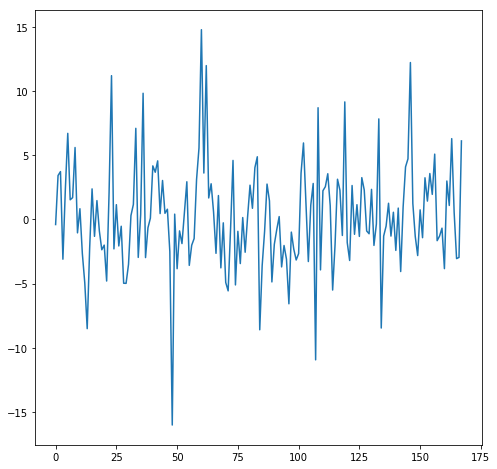

In [14]:
stationary_set = make_data_stationary(train_set, months_per_period=24)

## ARIMA model: correlation and PAC in dataset

In [15]:
def show_ac_pac(dataset):
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plot_acf(dataset, ax = plt.gca())
    plt.subplot(212)
    plot_pacf(dataset, ax = plt.gca())
    plt.show()

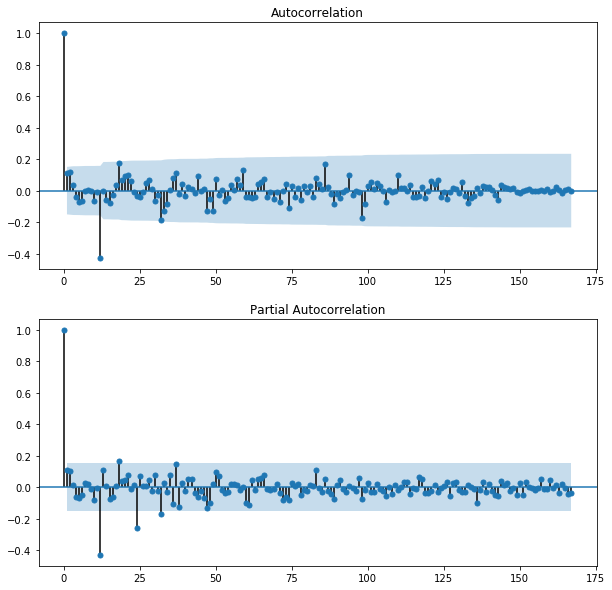

In [16]:
show_ac_pac(stationary_set)

## ARIMA model: Find hyperparameters

In [17]:
def evaluate_arima_model_hyp(ev_set, arima_order, bias=0):
    # Training set preparation
    ar_train_set = ev_set[:int(len(ev_set)/2)]
    ar_test_set = ev_set[int(len(ev_set)/2):]
    history = [x for x in ar_train_set]
    predictions = list()
    
    # make predictions
    for i in range(len(ar_test_set)):
        # difference data
        diff = difference(history)
        # predict
        model = ARIMA(diff, arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        yhat = bias + inverse_difference(history, yhat)
        predictions.append(yhat)
        # observation
        obs = ar_test_set[i]
        history.append(obs)
    # report performance
    mse = mean_squared_error(ar_test_set, predictions)
    rmse = np.sqrt(mse)
    return rmse

def evaluate_hyperparameters(dataset, arima_p, arima_d, arima_q):
    best_score = float('inf')
    best_cfg = None
    for p in arima_p:
        for d in arima_d:
            for q in arima_q:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model_hyp(dataset, order)
                    if rmse < best_score:
                        best_score = rmse
                        best_cfg = order
                    print('ARIMA order: {} and its RMSE: {}'.format(order, rmse))
                except:
                    pass
    print('Best ARIMA order: {} and RMSE: {}'.format(best_cfg, best_score))

In [18]:
p_values = [0, 1, 2, 12]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 12]
evaluate_hyperparameters(train_set, p_values, d_values, q_values)

ARIMA order: (0, 0, 0) and its RMSE: 3.797279505910114
ARIMA order: (0, 0, 1) and its RMSE: 3.8580762217977997
ARIMA order: (0, 0, 2) and its RMSE: 3.907876996937153
ARIMA order: (0, 0, 12) and its RMSE: 3.9429738185260614
ARIMA order: (0, 1, 0) and its RMSE: 5.507151780039958
ARIMA order: (0, 1, 1) and its RMSE: 3.8717363197805446
ARIMA order: (0, 1, 2) and its RMSE: 3.892099748150771
ARIMA order: (0, 2, 0) and its RMSE: 9.51259266999317
ARIMA order: (0, 2, 1) and its RMSE: 5.550274358004598
ARIMA order: (1, 0, 0) and its RMSE: 3.884218713520254
ARIMA order: (1, 1, 0) and its RMSE: 4.746135786847825
ARIMA order: (1, 1, 1) and its RMSE: 3.9155093640742686
ARIMA order: (1, 1, 2) and its RMSE: 3.7961307440579874
ARIMA order: (1, 2, 0) and its RMSE: 7.03438318062989
ARIMA order: (2, 0, 0) and its RMSE: 3.917237540955112
ARIMA order: (2, 1, 0) and its RMSE: 4.53272675608488
ARIMA order: (2, 1, 2) and its RMSE: 3.934175267006136
ARIMA order: (2, 2, 0) and its RMSE: 6.130304625370254
ARIMA o

## ARIMA: set model

               0
count  96.000000
mean   -0.147823
std     3.813164
min   -10.584347
25%    -2.433190
50%    -0.463674
75%     2.191216
max    11.508869


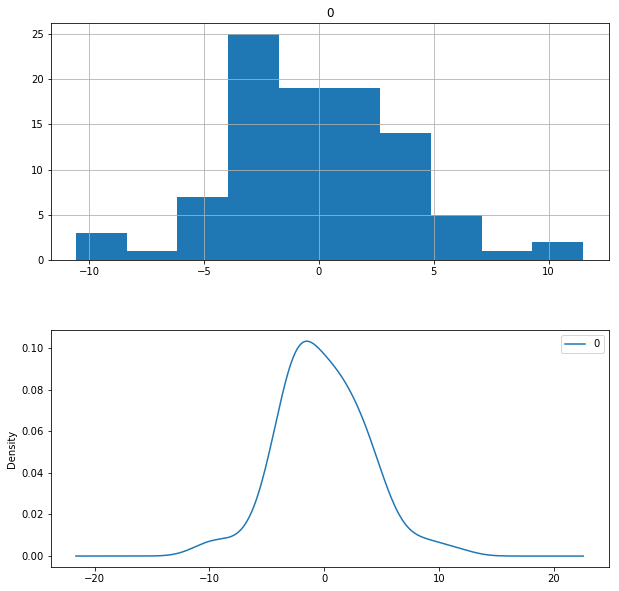

In [20]:
def evaluate_arima_model(ev_set, arima_order, bias=0):
    # Training set preparation
    ar_train_set = ev_set[:int(len(ev_set)/2)]
    ar_test_set = ev_set[int(len(ev_set)/2):]
    history = [x for x in ar_train_set]
    predictions = list()
    
    # make predictions
    for i in range(len(ar_test_set)):
        # difference data
        diff = difference(history)
        # predict
        model = ARIMA(diff, arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        yhat = bias + inverse_difference(history, yhat)
        predictions.append(yhat)
        # observation
        obs = ar_test_set[i]
        history.append(obs)
    # errors
    residuals = [ar_test_set[i]-predictions[i] for i in range(len(ar_test_set))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    # plot
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    residuals.hist(ax = plt.gca())
    plt.subplot(212)
    residuals.plot(kind = 'kde', ax = plt.gca())
    plt.show()
    
p_value = 1
d_value = 1
q_value = 2
evaluate_arima_model(train_set, (p_value, d_value, q_value), bias=0)

## ARIMA: include bias

RMSE: 3.77548449422
               0
count  96.000000
mean    0.443312
std     3.769049
min   -10.261146
25%    -2.249215
50%     0.388132
75%     2.938766
max    12.071112


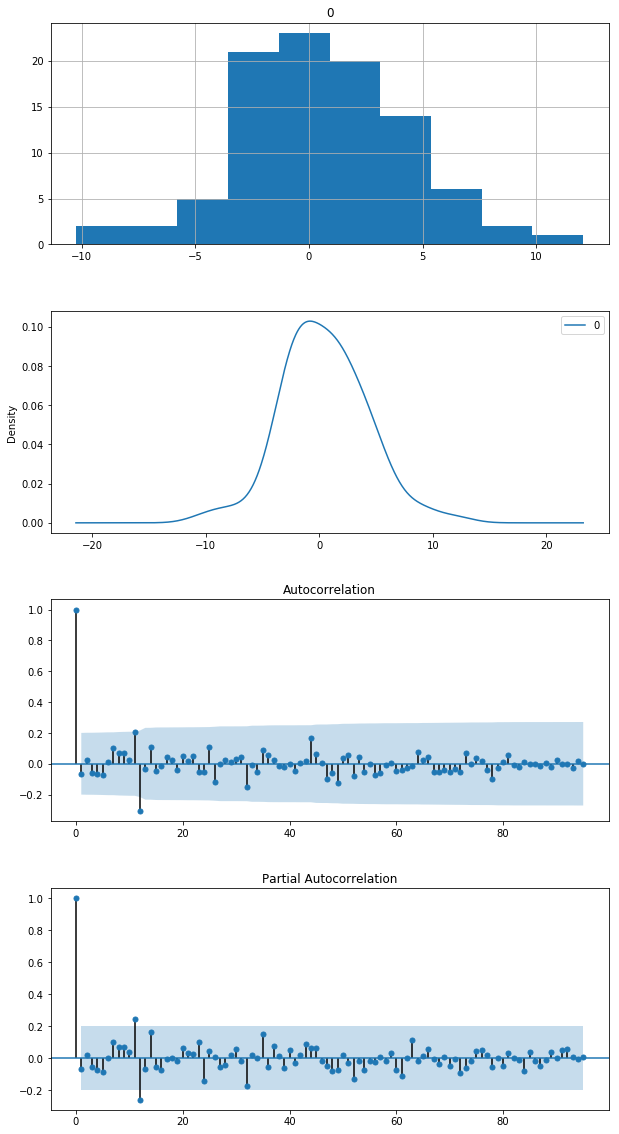

In [21]:
def evaluate_arima_model(ev_set, arima_order, bias = 0):
    # Training set preparation
    ar_train_set = ev_set[:int(len(ev_set)/2)]
    ar_test_set = ev_set[int(len(ev_set)/2):]
    history = [x for x in ar_train_set]
    predictions = list()
    # make predictions
    for i in range(len(ar_test_set)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        # predict
        model = ARIMA(diff, arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = bias + inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        # observation
        obs = ar_test_set[i]
        history.append(obs)
    # report performance
    mse = mean_squared_error(ar_test_set, predictions)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    # errors
    residuals = [ar_test_set[i]-predictions[i] for i in range(len(ar_test_set))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    # plot
    plt.figure(figsize=(10, 20))
    plt.subplot(411)
    residuals.hist(ax = plt.gca())
    plt.subplot(412)
    residuals.plot(kind = 'kde', ax = plt.gca())
    plt.subplot(413)
    plot_acf(residuals, ax = plt.gca())
    plt.subplot(414)
    plot_pacf(residuals, ax = plt.gca())
    plt.show()
    
p_value = 1
d_value = 1
q_value = 2
evaluate_arima_model(train_set, (p_value, d_value, q_value), bias=-0.147823)

## ARIMA: Validation

In [22]:
# patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

diff = difference(train_set, 12)

model = ARIMA(diff, order=(1, 1, 2))
model_fit = model.fit(trend = 'nc', disp=0)
bias = -0.147823
model_fit.save('output/model.pkl')
np.save('output/model_bias.npy', [bias])

In [23]:
def run_arima_validation(training_set,
                        validation_set,
                        arima_model,
                        bias_model,
                        model_order,
                        months_in_a_year):
    history = [x for x in training_set]
    # first prediction
    predictions = list()
    yhat = float(arima_model.forecast()[0])
    yhat = bias + inverse_difference(history, yhat, months_in_a_year)
    predictions.append(yhat[0])
    history.append(validation_set[0])
    # rolling forecasts
    for i in range(1, len(validation_set)):
        diff = difference(history, months_in_a_year)
        model = ARIMA(diff, model_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = bias + inverse_difference(history, yhat, months_in_a_year)
        predictions.append(yhat[0])
        # observation
        obs = validation_set[i]
        history.append(obs)
        print('> Predicted = %.3f, Expected = %.3f'%(yhat, obs))
    return predictions


validation_series = pd.Series.from_csv('input/validation.csv')
a_model = ARIMAResults.load('output/model.pkl')
bias = np.load('output/model_bias.npy')
predicted_values = run_arima_validation(train_set,
                                        validation_series,
                                        a_model,
                                        bias,
                                        (1, 1, 2),
                                        12)

> Predicted = 274.797, Expected = 277.867
> Predicted = 287.381, Expected = 284.509
> Predicted = 290.999, Expected = 291.372
> Predicted = 294.649, Expected = 298.616
> Predicted = 300.890, Expected = 302.088
> Predicted = 304.037, Expected = 300.911
> Predicted = 304.586, Expected = 299.321
> Predicted = 295.409, Expected = 297.815
> Predicted = 284.214, Expected = 285.700
> Predicted = 279.001, Expected = 278.720
> Predicted = 279.116, Expected = 271.855
> Predicted = 267.381, Expected = 268.311
> Predicted = 277.867, Expected = 271.567
> Predicted = 283.791, Expected = 286.964
> Predicted = 291.850, Expected = 289.420
> Predicted = 297.645, Expected = 297.241
> Predicted = 302.535, Expected = 299.728
> Predicted = 299.920, Expected = 299.128
> Predicted = 299.770, Expected = 300.257
> Predicted = 296.973, Expected = 290.421
> Predicted = 285.620, Expected = 289.128
> Predicted = 278.538, Expected = 279.248
> Predicted = 271.586, Expected = 272.645
> Predicted = 268.086, Expected = 

In [24]:
mse = mean_squared_error(validation_series, predicted_values)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

RMSE: 3.5879479642


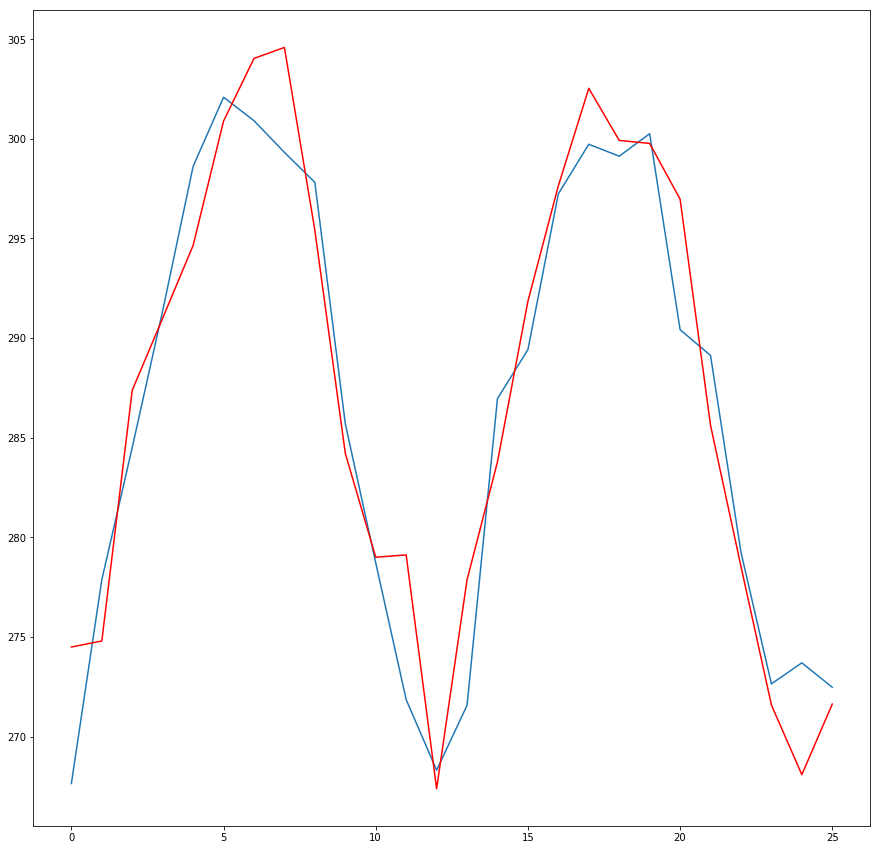

In [25]:
plt.figure(figsize=(15, 15))
plt.plot(validation_series.values)
plt.plot(predicted_values, color = 'red')
plt.show()